In [56]:
import psycopg2
import sys
import re
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
from scipy import stats, integrate
from os.path import isfile, expanduser
import json
import datetime

%matplotlib inline
import matplotlib.pyplot as plt

In [37]:
config_file = expanduser("~/ndexstats_config.json")
my_username = None
my_password = None
my_port = "5432"
my_host = "stats.ndexbio.org"
my_db_name = 'ndexstats'

if(isfile(config_file)):
    file = open(config_file, "r")
    data = json.load(file)
    file.close()
    if data.get("password") and data.get("username"):
        my_username = data.get("username")
        my_password = data.get("password")
    else:
        print("Error: " + config_file + " does not define username and password")
else:
    print("Error: " + config_file + " was not found")

In [38]:
# Define our connection string
#conn_string = "host=" + my_host + " port=" + my_port + " dbname=" + my_db_name + \
#    " user=" + my_username + " password=" + my_password
    
conn_string = "host='{}' port='{}'  dbname='{}'  user='{}'  password='{}'".format(
        my_host, 
        my_port, 
        my_db_name, 
        my_username, 
        my_password)

print("will connect with\n{}".format(conn_string))

get_network_by_day = "select date_trunc('day', start_time) as d, count(*) from request_record_raw  " + \
      "where function_name = 'getCompleteNetworkAsCX' " + \
      "and start_time > '2018-01-12' " + \
      "and start_time < '2018-02-12' " + \
      "group by d " + \
      "order by d asc;"

print("-----")
print(get_network_by_day)

get_anon_search_by_day = "select date_trunc('day', start_time) as d, count(*) from request_record_raw " + \
      "where function_name = 'searchNetwork' " + \
      "and start_time > '2018-01-12' " + \
      "and start_time < '2018-02-12' " + \
      "group by d " + \
      "order by d asc;"

print("-----")
print(get_anon_search_by_day)

will connect with
host='stats.ndexbio.org' port='5432'  dbname='ndexstats'  user='ndexstats'  password='dashboard2018'
-----
select date_trunc('day', start_time) as d, count(*) from request_record_raw  where function_name = 'getCompleteNetworkAsCX' and start_time > '2018-01-12' and start_time < '2018-02-12' group by d order by d asc;
-----
select date_trunc('day', start_time) as d, count(*) from request_record_raw where function_name = 'searchNetwork' and start_time > '2018-01-12' and start_time < '2018-02-12' group by d order by d asc;


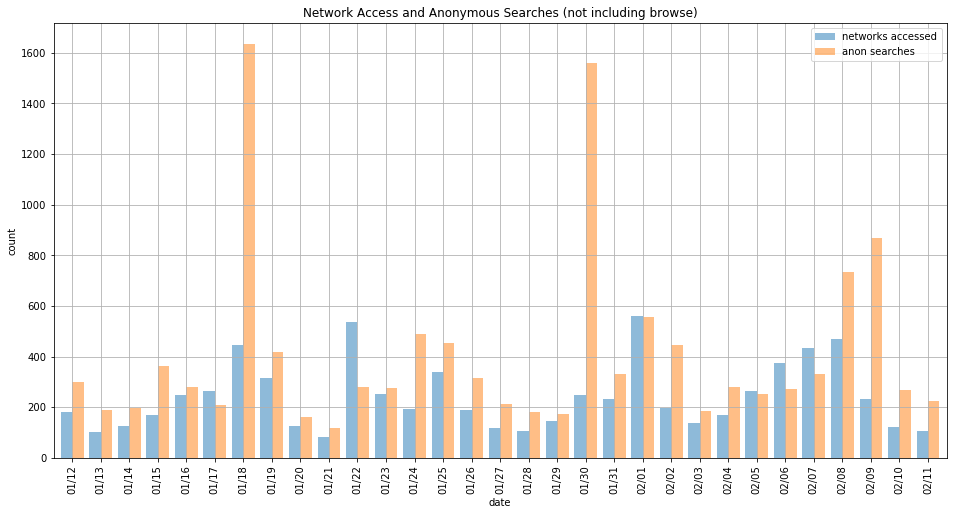

In [64]:
try:
    #conn = psycopg2.connect(conn_string)
    conn = psycopg2.connect(
        host=my_host,
        port=my_port,
        dbname=my_db_name,
        user=my_username,
        password=my_password)
    #print("-----")
    #print(conn)
    network_by_day_df = sqlio.read_sql_query(get_network_by_day, conn)
    network_by_day_df.rename(index=str, inplace=True, columns={"count": "networks accessed", "d": "date"})
    
    anon_by_day_df = sqlio.read_sql_query(get_anon_search_by_day, conn)
    anon_by_day_df.rename(index=str, inplace=True, columns={"count": "anon searches", "d": "date"})
    #print("-----")
    #
    conn.close()
    
    merged = pd.merge(network_by_day_df, anon_by_day_df, on='date')
    merged['date'] = merged['date'].apply(lambda x: x.strftime('%m/%d'))
    
    #merged.applymap(lambda x: )
    #print(merged)
                    
    merged.plot(
        x='date',
        #y='count',
        kind='bar',
        grid=True,
        #colormap='autumn',
        alpha=0.5,
        figsize=(16,8),
        title='Network Access and Anonymous Searches (not including browse)',
        width=.8, 
        linewidth=1.2 
        #stacked=True
    )

    plt.xlabel('date')
    plt.ylabel('count')
    fig_file = expanduser("~/stats/access_and_searches.jpg")
    plt.savefig(fig_file)
except:
    e = sys.exc_info()[0]
    print("Error: %s %tb" % e)
    sys.exit()